In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# I. Forecasting

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

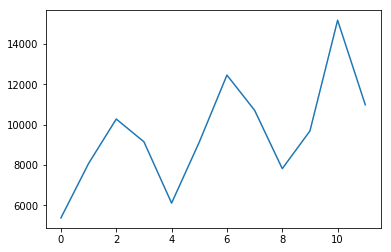

In [3]:
plt.plot(df['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

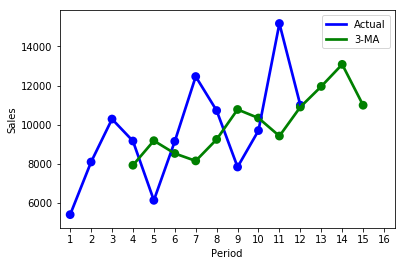

In [4]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    num_df = len(df)
    for m in range(0, to_period):
        if m < k:
            sale_predict = float('nan')
        else:
            history = df['Sales'][m-k:m]
            sale_predict = history.mean()
        moving_average_df.loc[m] = [m+1, sale_predict]
    
    moving_average_df['Period'] = moving_average_df['Period'].astype(int)
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

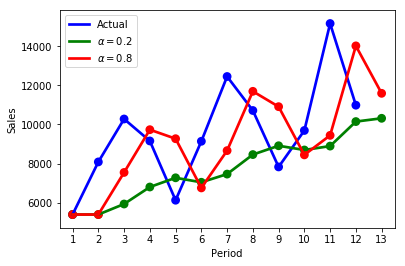

In [5]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df['Sales'][0]]
    num_df = len(df)
    for m in range(0, num_df):
        sale_predict = alpha * df['Sales'][m] + (1-alpha) * es_df['Sales'][m]
        es_df.loc[m+1] = [m+2, sale_predict]
        
    es_df['Period'] = es_df['Period'].astype(int)
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

### Using linear regression

In [6]:
def linear_regression(df):
    linear_df = df.copy()
    linear_df['PeriodSales'] = linear_df['Period'] * linear_df['Sales']
    linear_df['Period_2'] = linear_df['Period'] * linear_df['Period']
    linear_df['Sales_2'] = linear_df['Sales'] * linear_df['Sales']
    linear_sum = linear_df.sum()
    linear_mean = linear_df.mean()
    
    b = (linear_sum['PeriodSales'] - len(df) * linear_mean['Period'] * linear_mean['Sales']) \
        / (linear_sum['Period_2']- len(df) * linear_mean['Period'] * linear_mean['Period'])
    a = linear_mean['Sales'] - b * linear_mean['Period']
#     y = a+b*x
    return a,b

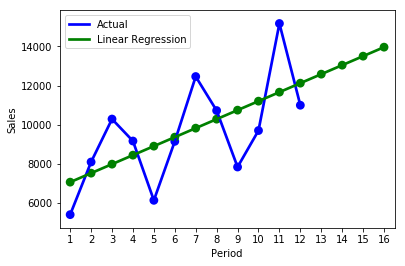

In [7]:
a,b = linear_regression(df)
linear_df = pd.DataFrame(columns=['Period','Sales'])
for m in range(1, 17):
    sale = a + b * m
    linear_df.loc[m-1] = [m,sale]
linear_df['Period'] = linear_df['Period'].astype(int)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=linear_df, color='g')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", "Linear Regression"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RankWarning: Polyfit may be poorly conditioned


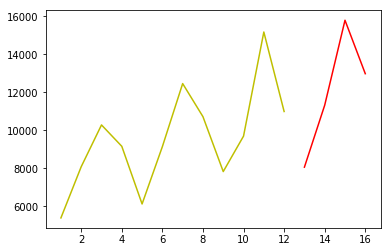

In [8]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    avg_df = season_df.apply(np.mean)
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I']/avg_df['I']
    seasonal_index_df['II'] = season_df['II']/avg_df['II']
    seasonal_index_df['III'] = season_df['III']/avg_df['III']
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    
    forecast_df['Sales'] = seasonal_index_df['Avg']*average_predict
    forecast_df['Period'] = months
#     forecast_df.index = forecast_df['Period']
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

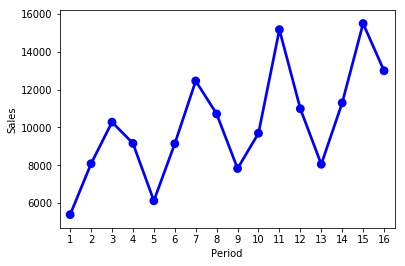

In [9]:
eval_df = pd.read_csv('actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)
sns.pointplot(x='Period', y='Sales', data=eval_df, color='b')

In [10]:
MAD = np.absolute(eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - linear_df['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Linear Regression", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - season_df['Sales'][0:4]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Linear Regression: 2309.1480186480185
MAD of Seasonality Method: 85.88221407247033


In [11]:
MSE = (eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df['Sales'][12:16] - linear_df['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Linear Regression", MSE))
MSE = (eval_df['Sales'][12:16] - season_df['Sales'][0:4])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Linear Regression: 7123661.909756519
MSE of Seasonality Method: 22206.089646322016


# II. Recommender Systems

## 1. Basics of Recommendation Algorithm

In [6]:
from scipy.spatial.distance import cosine
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error

In [7]:
M = np.asarray([[4,3,2,3], 
                [1,2,3,1],
                [np.nan,2,1,np.nan],
                [4,3,np.nan,np.nan],
#                [1,1,1,1],
               ])
print(M.shape)
print(np.nanmean(M, axis=0))
pd.DataFrame(M)

(4, 4)
[3.  2.5 2.  2. ]


,0,1,2,3
0,4.0,3.0,2.0,3.0
1,1.0,2.0,3.0,1.0
2,NaN,2.0,1.0,NaN
3,4.0,3.0,NaN,NaN


### Compute similarities

#### Cosine

In [8]:
import math
def cosine_similarity(v1,v2, metric='cosine'):
    if metric == 'correlation':
        v1 = v1 - np.nanmean(v1)
        v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if np.isnan(x) or np.isnan(y): continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user', metric='cosine'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]   
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = cosine_similarity(v1,v2,metric)
    return sim

In [9]:
cosine_similarity(M[0,:], M[2,:], 'cosine')

0.9922778767136677

In [10]:
sim_matrix(M, 'user')

array([[0.        , 0.79582243, 0.99227788, 1.        ],
       [0.79582243, 0.        , 0.86824314, 0.89442719],
       [0.99227788, 0.86824314, 0.        , 1.        ],
       [1.        , 0.89442719, 1.        , 0.        ]])

In [11]:
sim_matrix(M, 'item')

array([[0.        , 0.9649505 , 0.73994007, 0.99705449],
       [0.9649505 , 0.        , 0.90748521, 0.96476382],
       [0.73994007, 0.90748521, 0.        , 0.78935222],
       [0.99705449, 0.96476382, 0.78935222, 0.        ]])

#### Pearson

In [12]:
cosine_similarity(M[0,:], M[2,:], 'correlation')

0.7071067811865475

In [13]:
sim_matrix(M, 'user', 'correlation')

array([[ 0.        , -0.85280287,  0.70710678,  0.70710678],
       [-0.85280287,  0.        , -0.5547002 , -0.89442719],
       [ 0.70710678, -0.5547002 ,  0.        , -1.        ],
       [ 0.70710678, -0.89442719, -1.        ,  0.        ]])

In [14]:
sim_matrix(M, 'item', 'correlation')

array([[ 0.        ,  0.94280904, -0.89442719,  0.9486833 ],
       [ 0.94280904,  0.        ,  0.        ,  1.        ],
       [-0.89442719,  0.        ,  0.        , -0.70710678],
       [ 0.9486833 ,  1.        , -0.70710678,  0.        ]])

### a) Compute the missing rating in this table using user-based collaborative filtering (CF). (Use cosine similarity, then use Pearson similarity). Assume taking all neighbors

In [15]:
# Some tests
n_users, n_items = M.shape
avg_ratings = np.nanmean(M, axis=1)
sim_users = sim_matrix(M, 'user', 'cosine')
print(sim_users[2])
print(M[:,0])
print(avg_ratings)
print(M[:,0] - avg_ratings)
print(sim_users[2] * (M[:,0] - avg_ratings))

[0.99227788 0.86824314 0.         1.        ]
[ 4.  1. nan  4.]
[3.   1.75 1.5  3.5 ]
[ 1.   -0.75   nan  0.5 ]
[ 0.99227788 -0.65118236         nan  0.5       ]


In [16]:
def user_cf(M, metric='cosine'):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=1)
    sim_users = sim_matrix(M, 'user', metric)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[i] + np.nansum(sim_users[i] * (M[:,j] - avg_ratings)) / sum(sim_users[i])
    return pred

In [17]:
print("User-based CF (Cosine): \n" + str(pd.DataFrame(user_cf(M, 'cosine'))))
print("User-based CF (Pearson): \n" + str(pd.DataFrame(user_cf(M, 'correlation'))))

User-based CF (Cosine): 
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  1.794036  2.0  1.000000  1.272355
3  4.000000  3.0  3.368034  3.268237
User-based CF (Pearson): 
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  0.764822  2.0  1.000000  1.009169
3  4.000000  3.0  4.616077  2.935013


### b) Similarly, computing the missing rating using item-based CF.

In [18]:
def item_cf(M, metric='cosine'):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=0)
    sim_items = sim_matrix(M, 'item', metric)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[j] + np.nansum(sim_items[j] * (M[i,:] - avg_ratings)) / sum(sim_items[j])
    return pred

In [19]:
print("Item-based CF (Cosine): \n" + str(pd.DataFrame(item_cf(M, 'cosine'))))
print("Item-based CF (Pearson): \n" + str(pd.DataFrame(item_cf(M, 'correlation'))))

Item-based CF (Cosine): 
         0    1         2         3
0  4.00000  3.0  2.000000  3.000000
1  1.00000  2.0  3.000000  1.000000
2  2.54758  2.0  1.000000  1.537748
3  4.00000  3.0  2.489861  2.537748
Item-based CF (Pearson): 
          0    1         2        3
0  4.000000  3.0  2.000000  3.00000
1  1.000000  2.0  3.000000  1.00000
2  3.424268  2.0  1.000000  2.16681
3  4.000000  3.0  2.558482  3.16681


In [20]:
# M_test1 = np.asarray([[3,0,3,3], 
#                 [5,4,0,2],
#                 [1,2,4,2],
#                 [3,np.nan,1,0],
#                [2,2,0,1],
#                ])
# print("User-based CF (Cosine): \n" + str(pd.DataFrame(user_cf(M_test1, 'cosine'))))
# print("Item-based CF (Cosine): \n" + str(pd.DataFrame(item_cf(M_test1, 'cosine'))))

# M_test2 = np.asarray([[4,3,np.nan,3], 
#                 [1,2,3,1],
#                 [np.nan,2,1,np.nan],
#                 [4,3,2,4],
#                ])
# print("User-based CF (Pearson): \n" + str(pd.DataFrame(user_cf(M_test2, 'correlation'))))
# print("Item-based CF (Pearson): \n" + str(pd.DataFrame(item_cf(M_test2, 'correlation'))))

## 2. Evaluating Recommendation Algorithms

### Predictive Accuracy

In [21]:
M_result = np.asarray([[4,3,2,3], 
                [1,2,3,1],
                [1,2,1,2],
                [4,3,2,4]])
pd.DataFrame(M_result)

,0,1,2,3
0,4,3,2,3
1,1,2,3,1
2,1,2,1,2
3,4,3,2,4


In [22]:
def evaluateRS(ratings, groundtruth, method='user_cf', metric='cosine'):
    if method == 'user_cf':
        prediction = user_cf(ratings, metric)
    else:
        prediction = item_cf(ratings, metric)
    MSE = mean_squared_error(prediction, groundtruth)
    RMSE = round(sqrt(MSE),3)
    print("RMSE using {0} approach ({2}) is: {1}".format(method, RMSE, metric))
    print(pd.DataFrame(prediction))
    return

In [23]:
evaluateRS(M, M_result, 'user_cf', 'cosine')
evaluateRS(M, M_result, 'user_cf', 'correlation')
evaluateRS(M, M_result, 'item_cf', 'cosine')
evaluateRS(M, M_result, 'item_cf', 'correlation')

RMSE using user_cf approach (cosine) is: 0.472
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  1.794036  2.0  1.000000  1.272355
3  4.000000  3.0  3.368034  3.268237
RMSE using user_cf approach (correlation) is: 0.751
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  0.764822  2.0  1.000000  1.009169
3  4.000000  3.0  4.616077  2.935013
RMSE using item_cf approach (cosine) is: 0.558
         0    1         2         3
0  4.00000  3.0  2.000000  3.000000
1  1.00000  2.0  3.000000  1.000000
2  2.54758  2.0  1.000000  1.537748
3  4.00000  3.0  2.489861  2.537748
RMSE using item_cf approach (correlation) is: 0.657
          0    1         2        3
0  4.000000  3.0  2.000000  3.00000
1  1.000000  2.0  3.000000  1.00000
2  3.424268  2.0  1.000000  2.16681
3  4.000000  3.0  2.558482  3.16681


### Ranking Accuracy

In [24]:
import scipy.stats as stats

def evaluate_rank(ratings, groundtruth, method='user_cf', metric='cosine'):
    if method == 'user_cf':
        prediction = user_cf(ratings, metric)
    else:
        prediction = item_cf(ratings, metric)
    
    avg_tau = 0
    for i in range(n_users):
        tau, p_value = stats.kendalltau(M_result[i,:], prediction[i,:])
        avg_tau += tau
    avg_tau = avg_tau / n_users
    clear_output(wait=True)
    return avg_tau

results = []
for method in ['user_cf', 'item_cf']:
    for metric in ['cosine', 'correlation']:
        rank_acc = evaluate_rank(M, M_result, method, metric)
        results += ["Rank accuracy of {0} with {1} metric: {2}".format(method[1], metric, rank_acc)]
print("\n".join(results))

Rank accuracy of s with cosine metric: 0.6477056190747297
Rank accuracy of s with correlation metric: 0.56719350585564
Rank accuracy of t with cosine metric: 0.6369306393762916
Rank accuracy of t with correlation metric: 0.7282177322938193
